# Capstone

The company Amazon Mechanical Turk aimed to predict if their drivers would accept a coupon for food or beverage offered to them while they were driving. To do this, they conducted a survey to determine the drivin conditions when the coupon was offered, personal information about the driver, and whether the coupon was accepted.  

Data was sourced from https://archive.ics.uci.edu/dataset/603/in+vehicle+coupon+recommendation 



In [3]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, precision_recall_curve, recall_score, ConfusionMatrixDisplay, confusion_matrix

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Inspecting and Cleaning Data

In [6]:
untouched_df = pd.read_csv('in-vehicle-coupon-recommendation.csv')

In [7]:
untouched_df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [8]:
untouched_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

Column 'car' is dropped as it as only 108 values. 
Rows with empty values are dropped.

In [10]:
#remove car and null
df = untouched_df.drop('car', axis=1)
df = df.dropna()
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 12079 entries, 22 to 12683
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12079 non-null  object
 1   passanger             12079 non-null  object
 2   weather               12079 non-null  object
 3   temperature           12079 non-null  int64 
 4   time                  12079 non-null  object
 5   coupon                12079 non-null  object
 6   expiration            12079 non-null  object
 7   gender                12079 non-null  object
 8   age                   12079 non-null  object
 9   maritalStatus         12079 non-null  object
 10  has_children          12079 non-null  int64 
 11  education             12079 non-null  object
 12  occupation            12079 non-null  object
 13  income                12079 non-null  object
 14  Bar                   12079 non-null  object
 15  CoffeeHouse           12079 non-null  ob

(12079, 25)

In [11]:
df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
22,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Male,21,Single,...,less1,4~8,4~8,less1,1,0,0,0,1,1
23,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Male,21,Single,...,less1,4~8,4~8,less1,1,0,0,0,1,0
24,No Urgent Place,Friend(s),Sunny,80,10AM,Bar,1d,Male,21,Single,...,less1,4~8,4~8,less1,1,0,0,0,1,1
25,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Male,21,Single,...,less1,4~8,4~8,less1,1,1,0,0,1,0
26,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Male,21,Single,...,less1,4~8,4~8,less1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,1,1,0,1,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12079 entries, 22 to 12683
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12079 non-null  object
 1   passanger             12079 non-null  object
 2   weather               12079 non-null  object
 3   temperature           12079 non-null  int64 
 4   time                  12079 non-null  object
 5   coupon                12079 non-null  object
 6   expiration            12079 non-null  object
 7   gender                12079 non-null  object
 8   age                   12079 non-null  object
 9   maritalStatus         12079 non-null  object
 10  has_children          12079 non-null  int64 
 11  education             12079 non-null  object
 12  occupation            12079 non-null  object
 13  income                12079 non-null  object
 14  Bar                   12079 non-null  object
 15  CoffeeHouse           12079 non-null  ob

In [13]:
catcols = df.select_dtypes('object')
catcols.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12079 entries, 22 to 12683
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12079 non-null  object
 1   passanger             12079 non-null  object
 2   weather               12079 non-null  object
 3   time                  12079 non-null  object
 4   coupon                12079 non-null  object
 5   expiration            12079 non-null  object
 6   gender                12079 non-null  object
 7   age                   12079 non-null  object
 8   maritalStatus         12079 non-null  object
 9   education             12079 non-null  object
 10  occupation            12079 non-null  object
 11  income                12079 non-null  object
 12  Bar                   12079 non-null  object
 13  CoffeeHouse           12079 non-null  object
 14  CarryAway             12079 non-null  object
 15  RestaurantLessThan20  12079 non-null  ob

In [14]:
cclist = list(catcols.columns)
cc_dict = {}
binary = {}
for c in cclist:
    vc = df[c].value_counts()
    cc_dict[c] = vc
    if vc.shape[0] == 2:
        binary[c] = vc

print(cc_dict)
print(binary)
print(catcols.occupation.value_counts().shape[0])

{'destination': destination
No Urgent Place    5970
Home               3085
Work               3024
Name: count, dtype: int64, 'passanger': passanger
Alone        6969
Friend(s)    3148
Partner      1024
Kid(s)        938
Name: count, dtype: int64, 'weather': weather
Sunny    9601
Snowy    1331
Rainy    1147
Name: count, dtype: int64, 'time': time
6PM     3078
7AM     3024
10AM    2158
2PM     1916
10PM    1903
Name: count, dtype: int64, 'coupon': coupon
Coffee House             3816
Restaurant(<20)          2653
Carry out & Take away    2280
Bar                      1913
Restaurant(20-50)        1417
Name: count, dtype: int64, 'expiration': expiration
1d    6760
2h    5319
Name: count, dtype: int64, 'gender': gender
Female    6199
Male      5880
Name: count, dtype: int64, 'age': age
21         2537
26         2399
31         1925
50plus     1732
36         1253
41         1065
46          664
below21     504
Name: count, dtype: int64, 'maritalStatus': maritalStatus
Married partner    

In [15]:
print(f'occupation has {df['occupation'].nunique()} subcategories.')

occupation has 25 subcategories.


reducing categories in occupation, merging those with under 1000 entries

In [17]:
oc = df['occupation']
o = list(oc.unique())
keep = ['Unemployed', 'Student', 'Computer & Mathematical', 'Sales & Related']
change = [ oo for oo in o if oo not in keep]
print(len(change), len(o))

mapping_dict = {}
for k in keep:
    mapping_dict[k] = k
#print(mapping_dict)
for c in change:
    mapping_dict[c] = 'Other'
#print(mapping_dict)

oc = oc.replace(mapping_dict)

df['occupation'] = oc


oc.unique()
df['occupation'].value_counts()

21 25


occupation
Other                      6328
Unemployed                 1814
Student                    1497
Computer & Mathematical    1368
Sales & Related            1072
Name: count, dtype: int64

## EDA

### Univariate

#### Categorical Data

Ordinal: time, expiration, age, income, Bar, CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50 (9)

Binary: expiration, gender

occupation has too many options


17


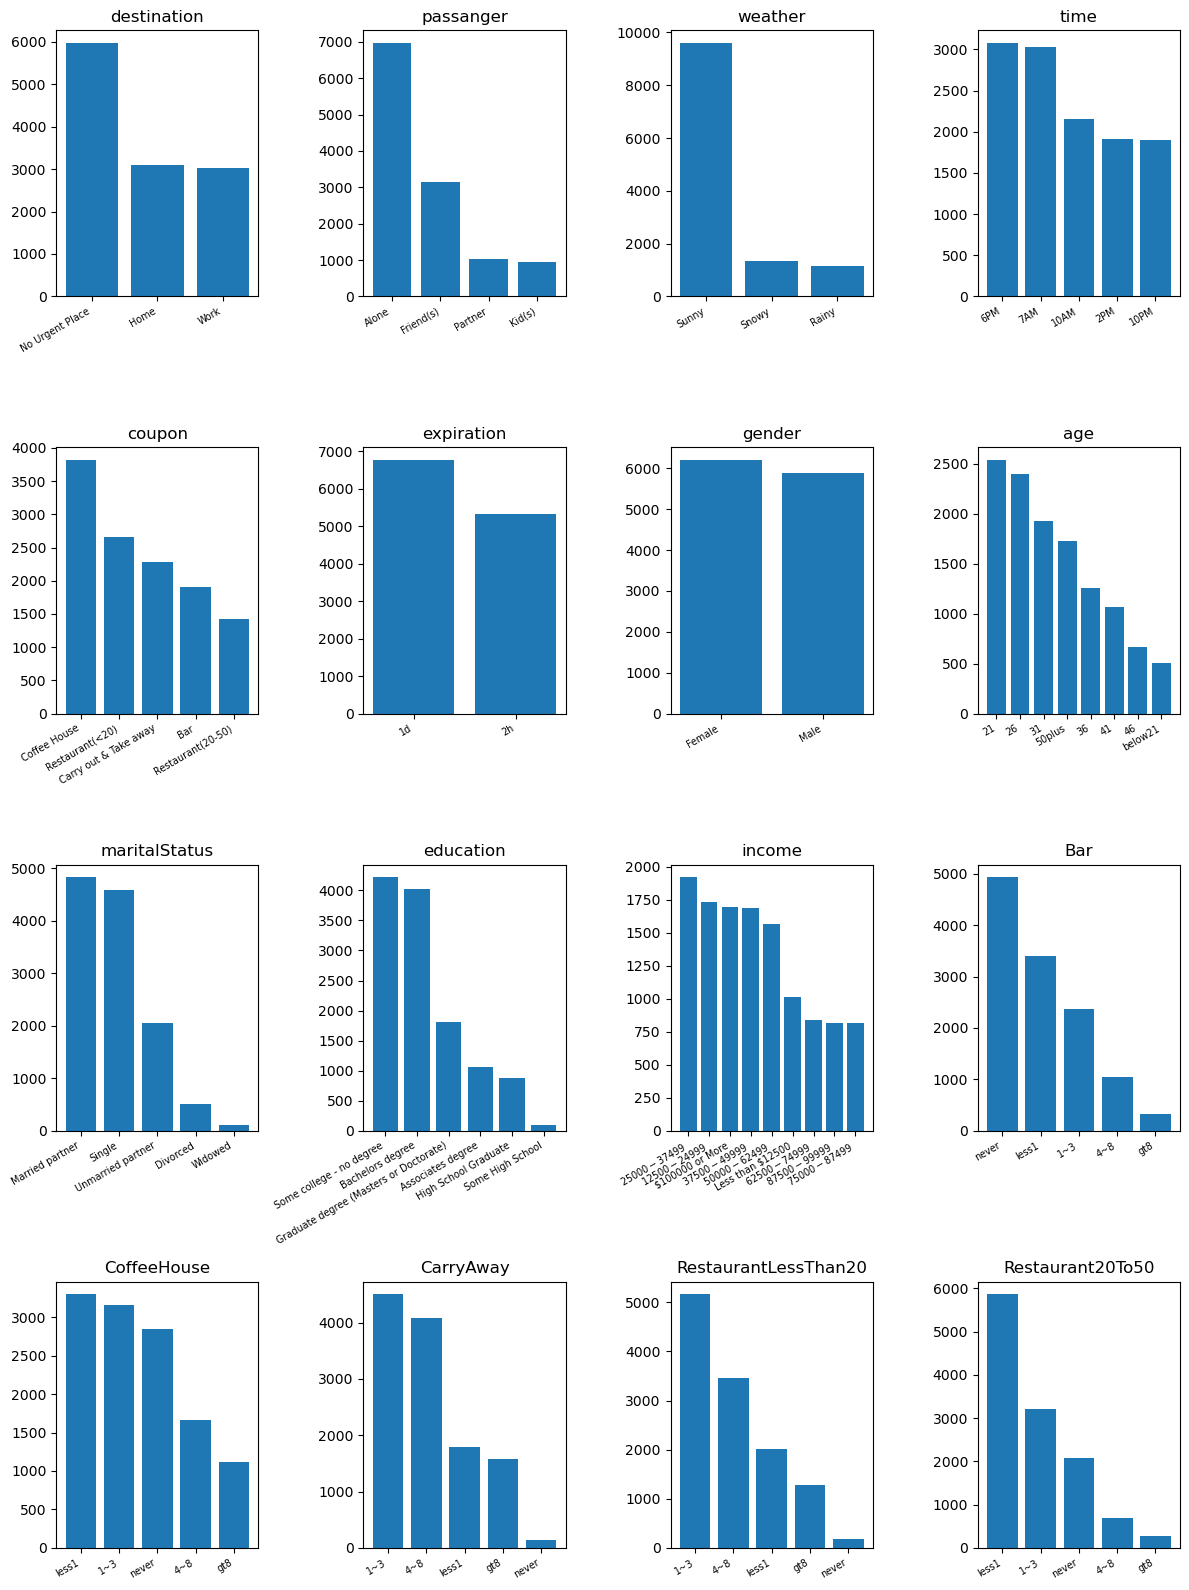

In [22]:
#categorical
print(len(list(catcols)))

fig, axs = plt.subplots(4,4)
axs = axs.flatten()

fig.set_size_inches(12,16)
for i, c in enumerate(list(catcols.drop('occupation', axis=1).columns)):
    cc = catcols[c].value_counts()
    axs[i].bar(cc.index, cc)
    #axs[i].bar_label(ax.containers[0])
    axs[i].set_title(c)
    plt.setp(axs[i].get_xticklabels(), rotation=30, horizontalalignment='right', fontsize='x-small')

plt.tight_layout()
    
    


Text(0.5, 1.0, 'Occupation after Merging')

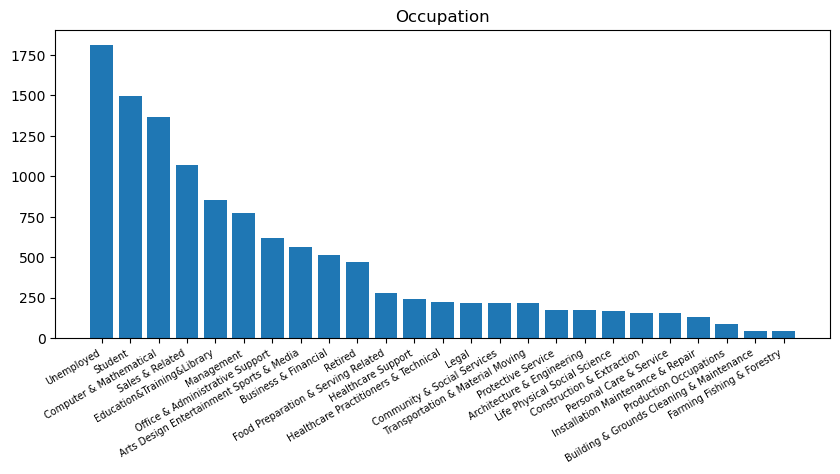

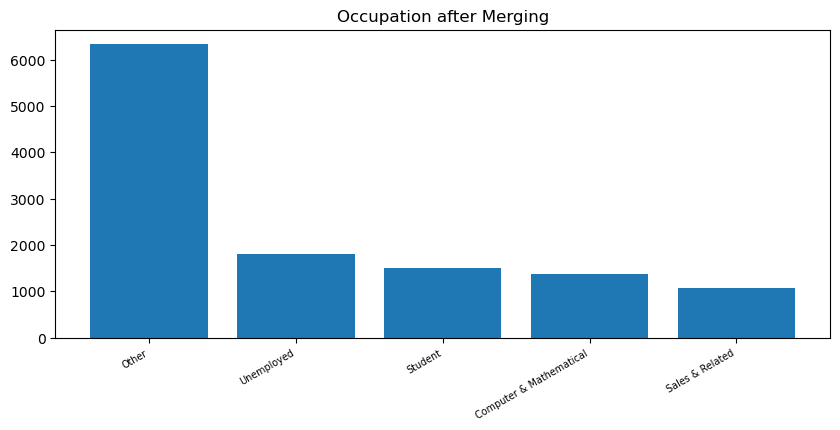

In [23]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,4)
c = catcols['occupation'].value_counts()
ax.bar(c.index, c)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize='x-small')
plt.title('Occupation')

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,4)
c = df['occupation'].value_counts()
ax.bar(c.index, c)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize='x-small')
plt.title('Occupation after Merging')

#### Numerical

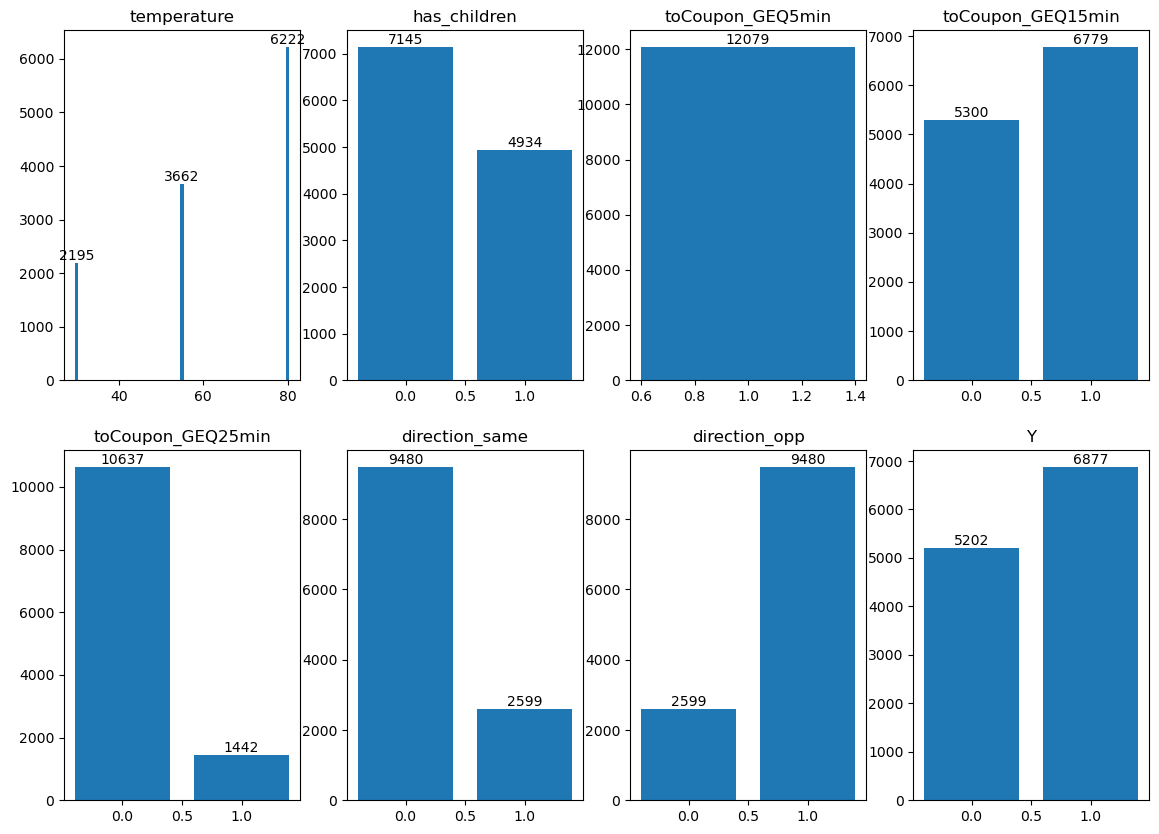

In [25]:
int = df.select_dtypes('int64')


fig, axs = plt.subplots(2,4)
axs = axs.flatten()
fig.set_size_inches(14,10)

for i, n in enumerate(list(int.columns)):
    axs[i].bar(int[n].value_counts().index, int[n].value_counts())
    axs[i].bar_label(axs[i].containers[0])
    axs[i].set_title(n)




toCoupon_GEQ5min will be dropped as it has one value.

### Mulitvariate

#### Numerical

Text(0.5, 1.0, 'Correlation between numerical values in the dataset')

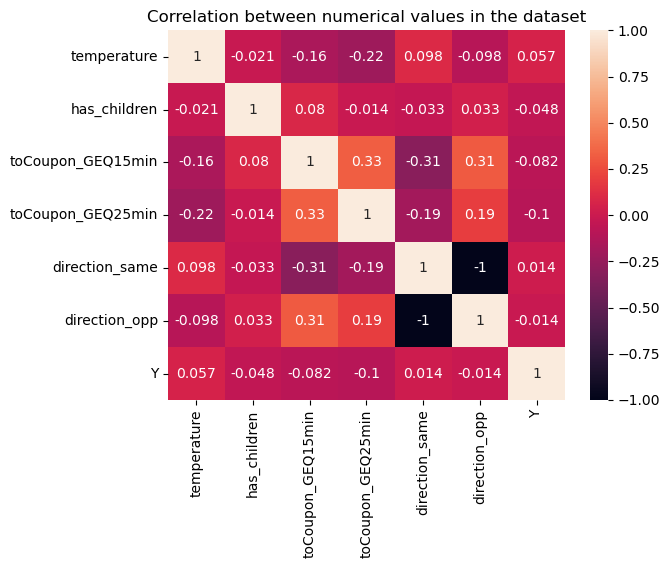

In [29]:
sns.heatmap(df.drop(['toCoupon_GEQ5min'], axis=1).select_dtypes('int64').corr(), annot=True)
plt.title('Correlation between numerical values in the dataset')


Text(0.5, 1.0, 'Values of "toCoupon_GEQ15min" \n(Distance to collect the coupon is greater than or equal to 15min)')

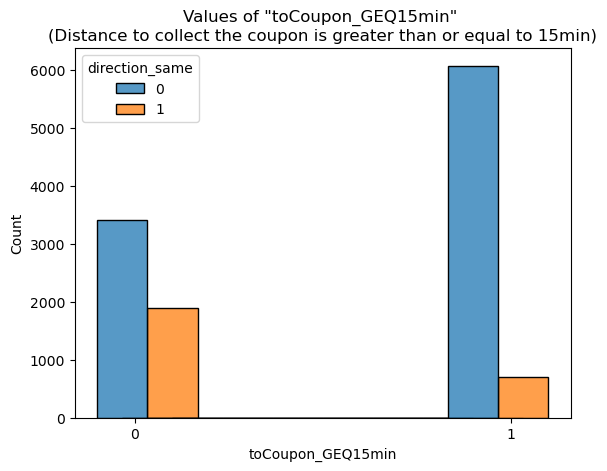

In [30]:
ee = sns.histplot(data=df, x='toCoupon_GEQ15min', hue='direction_same', multiple='dodge', shrink=4)
ee.set(xticks=[0,1])
plt.title('Values of "toCoupon_GEQ15min" \n(Distance to collect the coupon is greater than or equal to 15min)')

Text(0.5, 1.0, 'Values of "toCoupon_GEQ25min" \n(Distance to collect the coupon is greater than or equal to 25min)')

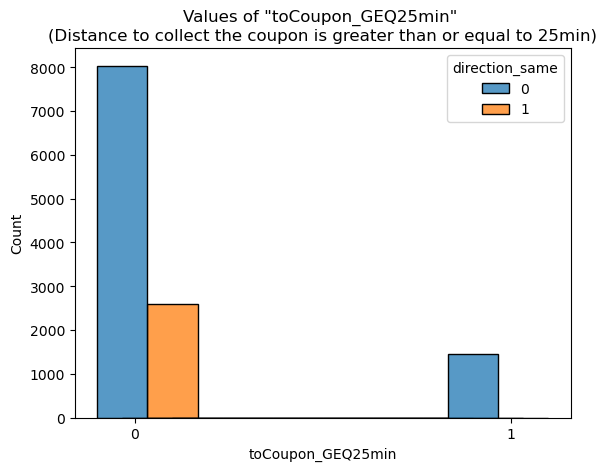

In [31]:
eee = sns.histplot(data=df, x='toCoupon_GEQ25min', hue='direction_same', multiple='dodge', shrink=4)
eee.set(xticks=list(range(0,2)))
plt.title('Values of "toCoupon_GEQ25min" \n(Distance to collect the coupon is greater than or equal to 25min)')

Text(0.5, 1.0, 'Values of "toCoupon_GEQ25min" with Different Values for Y (target)')

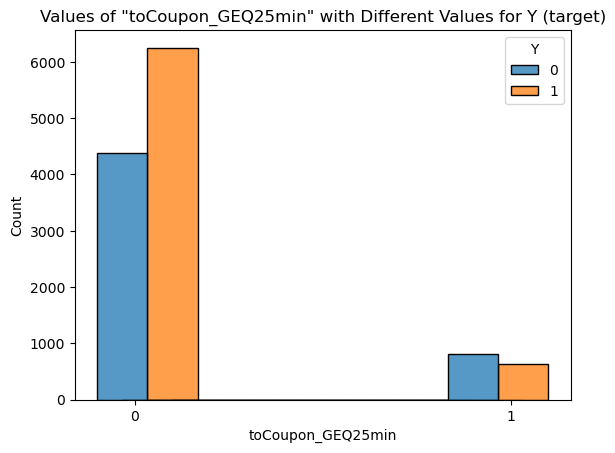

In [32]:
e = sns.histplot(data=df, x='toCoupon_GEQ25min', hue='Y', multiple='dodge', shrink=4)
e.set(xticks=list(range(0,2)))
plt.title('Values of "toCoupon_GEQ25min" with Different Values for Y (target)')

Y = 1 means accpeting the coupon.

All columns with integers are binary except temperature, which has 3 values, 80, 55 and 30.

direction_same and direction_opp are opposites and only one is needed, toCoupon_GEQ5min will be dropped.

toCoupon_GEQ5min only has 1 value, 1, and will be dropped.

In [35]:
# droping from df
df = df.drop(['direction_opp', 'toCoupon_GEQ5min'], axis=1)

#### Categorical

In [37]:
l = df.select_dtypes('object')
per = []
for a in l:
    data = df[[a, 'Y']]
    c = data.groupby(a).value_counts(normalize=True)
    c = c.round(2)
    per.append(c)

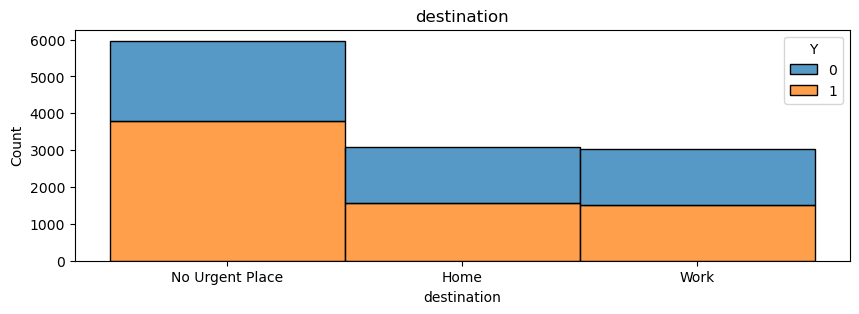

destination      Y
Home             1    0.51
                 0    0.49
No Urgent Place  1    0.63
                 0    0.37
Work             1    0.50
                 0    0.50
Name: proportion, dtype: float64


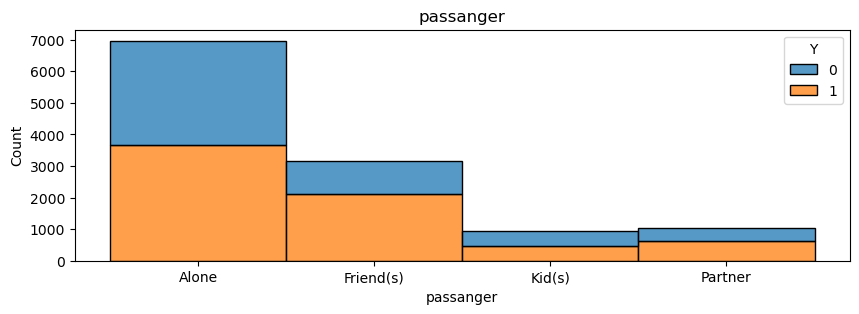

passanger  Y
Alone      1    0.53
           0    0.47
Friend(s)  1    0.68
           0    0.32
Kid(s)     0    0.50
           1    0.50
Partner    1    0.59
           0    0.41
Name: proportion, dtype: float64


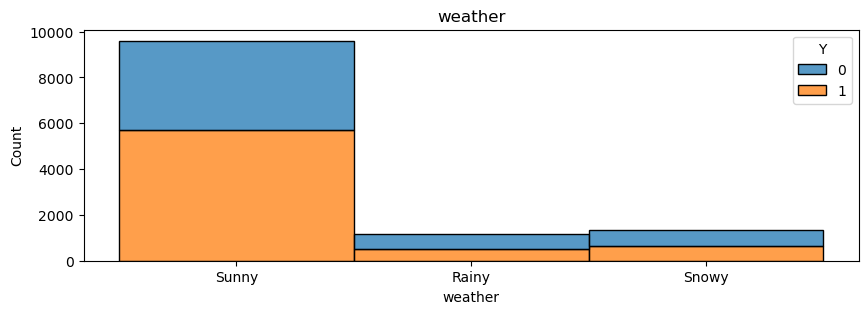

weather  Y
Rainy    0    0.54
         1    0.46
Snowy    0    0.52
         1    0.48
Sunny    1    0.60
         0    0.40
Name: proportion, dtype: float64


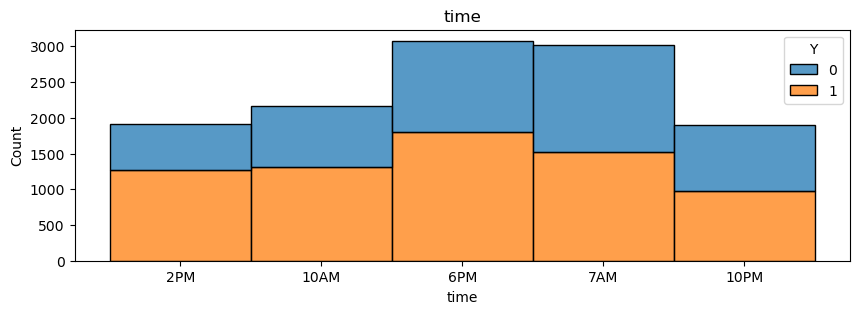

time  Y
10AM  1    0.61
      0    0.39
10PM  1    0.52
      0    0.48
2PM   1    0.66
      0    0.34
6PM   1    0.58
      0    0.42
7AM   1    0.50
      0    0.50
Name: proportion, dtype: float64


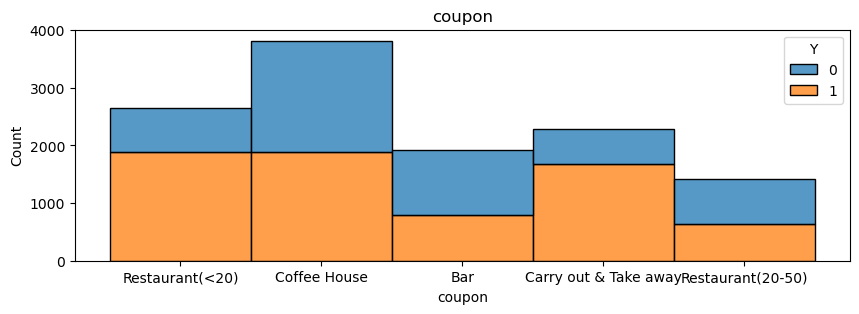

coupon                 Y
Bar                    0    0.59
                       1    0.41
Carry out & Take away  1    0.74
                       0    0.26
Coffee House           0    0.50
                       1    0.50
Restaurant(20-50)      0    0.55
                       1    0.45
Restaurant(<20)        1    0.71
                       0    0.29
Name: proportion, dtype: float64


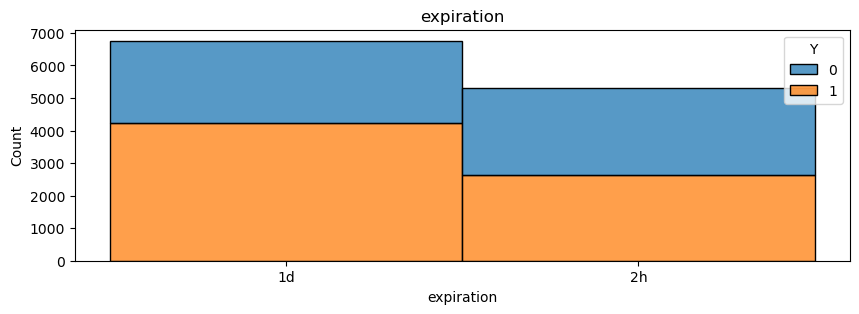

expiration  Y
1d          1    0.63
            0    0.37
2h          0    0.50
            1    0.50
Name: proportion, dtype: float64


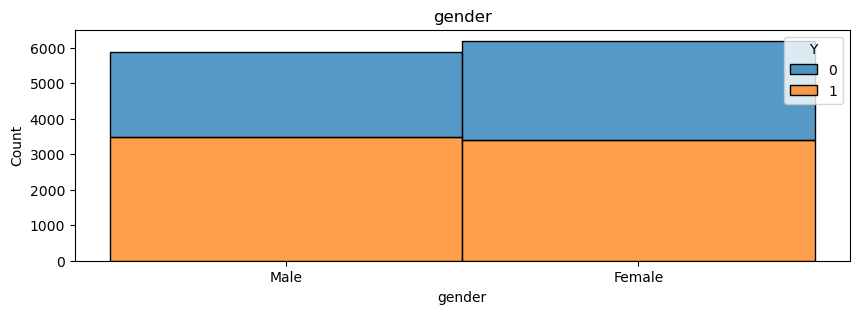

gender  Y
Female  1    0.55
        0    0.45
Male    1    0.59
        0    0.41
Name: proportion, dtype: float64


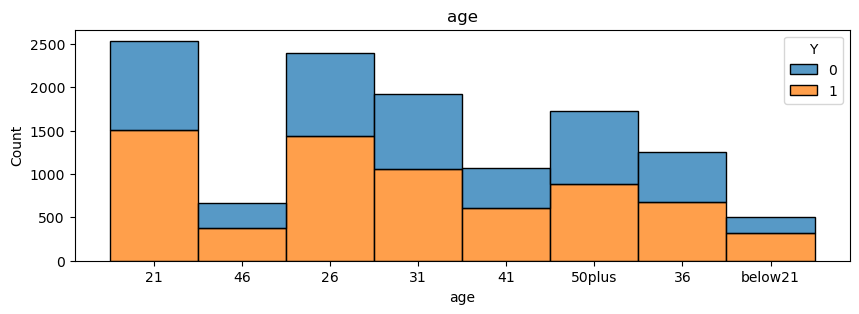

age      Y
21       1    0.59
         0    0.41
26       1    0.60
         0    0.40
31       1    0.55
         0    0.45
36       1    0.54
         0    0.46
41       1    0.57
         0    0.43
46       1    0.58
         0    0.42
50plus   1    0.51
         0    0.49
below21  1    0.63
         0    0.37
Name: proportion, dtype: float64


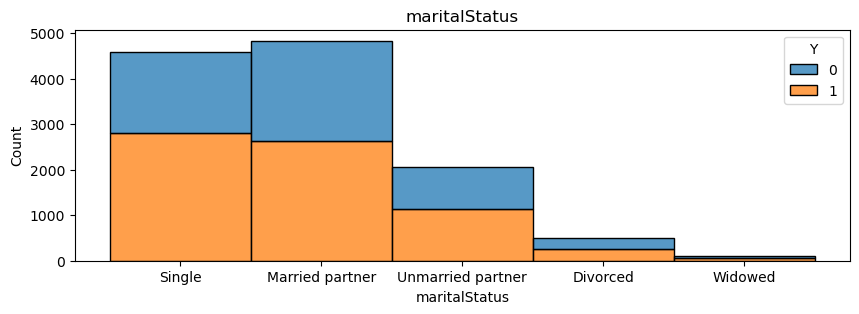

maritalStatus      Y
Divorced           1    0.53
                   0    0.47
Married partner    1    0.54
                   0    0.46
Single             1    0.61
                   0    0.39
Unmarried partner  1    0.56
                   0    0.44
Widowed            0    0.53
                   1    0.47
Name: proportion, dtype: float64


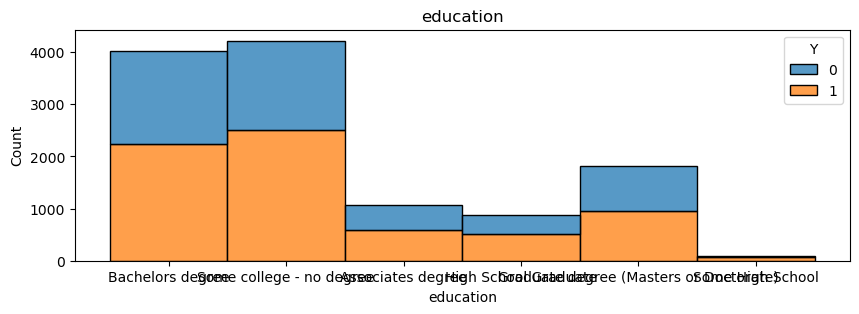

education                               Y
Associates degree                       1    0.56
                                        0    0.44
Bachelors degree                        1    0.56
                                        0    0.44
Graduate degree (Masters or Doctorate)  1    0.53
                                        0    0.47
High School Graduate                    1    0.59
                                        0    0.41
Some High School                        1    0.72
                                        0    0.28
Some college - no degree                1    0.59
                                        0    0.41
Name: proportion, dtype: float64


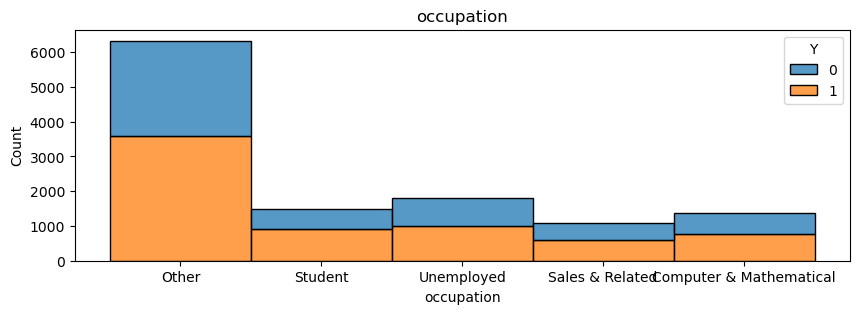

occupation               Y
Computer & Mathematical  1    0.56
                         0    0.44
Other                    1    0.57
                         0    0.43
Sales & Related          1    0.56
                         0    0.44
Student                  1    0.61
                         0    0.39
Unemployed               1    0.55
                         0    0.45
Name: proportion, dtype: float64


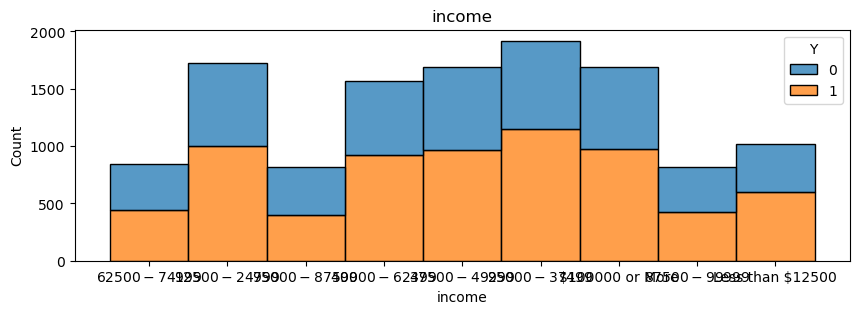

income            Y
$100000 or More   1    0.58
                  0    0.42
$12500 - $24999   1    0.58
                  0    0.42
$25000 - $37499   1    0.60
                  0    0.40
$37500 - $49999   1    0.57
                  0    0.43
$50000 - $62499   1    0.59
                  0    0.41
$62500 - $74999   1    0.53
                  0    0.47
$75000 - $87499   0    0.51
                  1    0.49
$87500 - $99999   1    0.52
                  0    0.48
Less than $12500  1    0.59
                  0    0.41
Name: proportion, dtype: float64


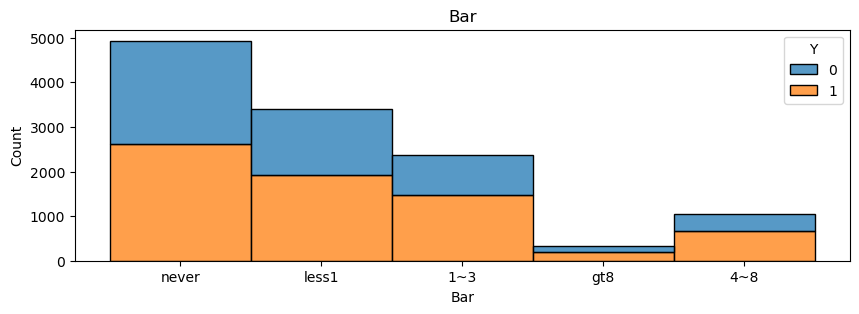

Bar    Y
1~3    1    0.62
       0    0.38
4~8    1    0.64
       0    0.36
gt8    1    0.57
       0    0.43
less1  1    0.57
       0    0.43
never  1    0.53
       0    0.47
Name: proportion, dtype: float64


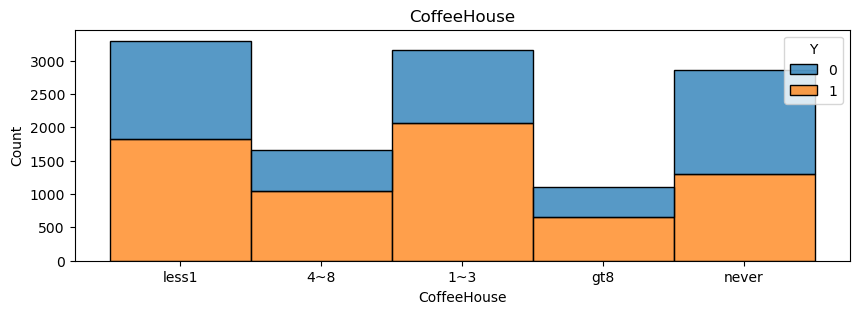

CoffeeHouse  Y
1~3          1    0.65
             0    0.35
4~8          1    0.63
             0    0.37
gt8          1    0.58
             0    0.42
less1        1    0.55
             0    0.45
never        0    0.54
             1    0.46
Name: proportion, dtype: float64


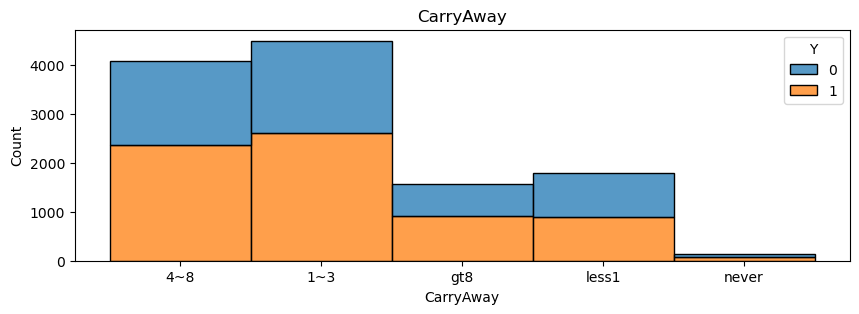

CarryAway  Y
1~3        1    0.58
           0    0.42
4~8        1    0.58
           0    0.42
gt8        1    0.58
           0    0.42
less1      1    0.50
           0    0.50
never      1    0.55
           0    0.45
Name: proportion, dtype: float64


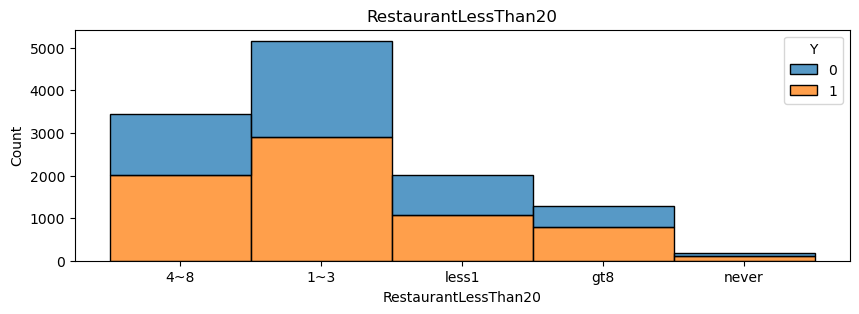

RestaurantLessThan20  Y
1~3                   1    0.56
                      0    0.44
4~8                   1    0.58
                      0    0.42
gt8                   1    0.61
                      0    0.39
less1                 1    0.54
                      0    0.46
never                 1    0.59
                      0    0.41
Name: proportion, dtype: float64


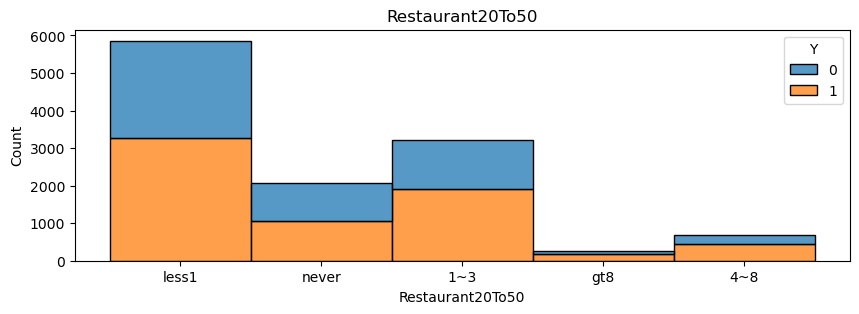

Restaurant20To50  Y
1~3               1    0.60
                  0    0.40
4~8               1    0.65
                  0    0.35
gt8               1    0.66
                  0    0.34
less1             1    0.56
                  0    0.44
never             1    0.52
                  0    0.48
Name: proportion, dtype: float64


In [38]:
for i,a in enumerate(l):
    fig, ax = plt.subplots(1,1)
    ax = sns.histplot(data=df, x=df[a], hue='Y', multiple='stack')
    pe = per[i]
    plt.title(a)
    fig.set_size_inches(10,3)
    plt.show()
    print(pe)

## Data Preparation

### Splitting Data

In [41]:
# split into train, val and test

X = df.drop('Y', axis=1)
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, random_state=22)


### Encoding Ordinal Data

In [43]:
to_ordinal = ['time', 'age', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']

In [44]:
to_ordinal_cat = [['7AM', '10AM', '2PM', '6PM', '10PM'], ['below21', '21', '26', '31', '36', '41', '46', '50plus'], ['Less than $12500', '$12500 - $24999', '$25000 - $37499', '$37500 - $49999', '$50000 - $62499', '$62500 - $74999', '$75000 - $87499', '$87500 - $99999', '$100000 or More'], ['never', 'less1', '1~3', '4~8', 'gt8'], ['never', 'less1', '1~3', '4~8', 'gt8'], ['never', 'less1', '1~3', '4~8', 'gt8'], ['never', 'less1', '1~3', '4~8', 'gt8'], ['never', 'less1', '1~3', '4~8', 'gt8']]
enc = OrdinalEncoder(categories=to_ordinal_cat)
n = enc.fit_transform(df[to_ordinal])

In [45]:
# ordinal encoder
enc = OrdinalEncoder(categories=to_ordinal_cat)
new = enc.fit_transform(df[to_ordinal])

dfo = df
dfo = dfo.reset_index()

odf = pd.DataFrame(new, columns=to_ordinal)
#odf.info()

dfo = dfo.drop(to_ordinal, axis=1)
for o in to_ordinal:
    dfo[o] = odf[o]

dfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 12079 non-null  int64  
 1   destination           12079 non-null  object 
 2   passanger             12079 non-null  object 
 3   weather               12079 non-null  object 
 4   temperature           12079 non-null  int64  
 5   coupon                12079 non-null  object 
 6   expiration            12079 non-null  object 
 7   gender                12079 non-null  object 
 8   maritalStatus         12079 non-null  object 
 9   has_children          12079 non-null  int64  
 10  education             12079 non-null  object 
 11  occupation            12079 non-null  object 
 12  toCoupon_GEQ15min     12079 non-null  int64  
 13  toCoupon_GEQ25min     12079 non-null  int64  
 14  direction_same        12079 non-null  int64  
 15  Y                  

### Encoding

In [47]:
# use ordinal and one hot encoder to transform data
dfocatcols = dfo.select_dtypes('object').columns.tolist()
print(dfocatcols)

transformer = make_column_transformer((OneHotEncoder(), dfocatcols), (OrdinalEncoder(categories=to_ordinal_cat), to_ordinal), remainder = StandardScaler())

X_train = transformer.fit_transform(X_train)
X_test = transformer.fit_transform(X_test)
X_train_2 = transformer.fit_transform(X_train_2)
X_val = transformer.fit_transform(X_val)

['destination', 'passanger', 'weather', 'coupon', 'expiration', 'gender', 'maritalStatus', 'education', 'occupation']


## Fitting Models

### Fitting using Default Parameters

In [50]:
print(y.value_counts(normalize=True))

Y
1    0.569335
0    0.430665
Name: proportion, dtype: float64


In [51]:
# cross val score
def CVS(model, X_train, y_train):
    
    
    acc = cross_val_score(model, X_train, y_train)
    
    print('accuracy: ',acc, acc.mean())

    pres = cross_val_score(model, X_train, y_train, scoring='precision').mean()
    rec  = cross_val_score(model, X_train, y_train, scoring='recall').mean()
    print('precision: ', pres, '\nrecall: ',rec)

    return acc, pres, rec

In [52]:
dacc, dres, drec = CVS(DummyClassifier(), X_train, y_train)

accuracy:  [0.57064018 0.57064018 0.57064018 0.57064018 0.57040309] 0.5705927597232024
precision:  0.5705927597232024 
recall:  1.0


In [53]:
kn_acc, kn_pres, kn_rec = CVS(KNeighborsClassifier(), X_train, y_train)

accuracy:  [0.65728477 0.6495585  0.65452539 0.65949227 0.64881281] 0.6539347475508391
precision:  0.6817197095428583 
recall:  0.7382458183615729


In [54]:
# runs slow
cvs_acc, cvs_res, cvs_rec = CVS(SVC(), X_train, y_train)

accuracy:  [0.71467991 0.73785872 0.72682119 0.71412804 0.70403092] 0.7195037561724219
precision:  0.7326473883993013 
recall:  0.8003435937093328


In [55]:
tree_acc, tree_pres, tree_rec = CVS(DecisionTreeClassifier(), X_train, y_train)

accuracy:  [0.67770419 0.65452539 0.67163355 0.68267108 0.64549972] 0.6664067880489967
precision:  0.7125556508323254 
recall:  0.7055482426164802


In [56]:
rf_acc, rf_pres, rf_rec = CVS(RandomForestClassifier(), X_train, y_train)

accuracy:  [0.74448124 0.75496689 0.73730684 0.73344371 0.72722253] 0.7394842408972394
precision:  0.7529464933254191 
recall:  0.8073089029155845


In [57]:
xgb_acc, xgb_pres, xgb_rec = CVS(GradientBoostingClassifier(), X_train, y_train)

accuracy:  [0.72461369 0.74227373 0.72571744 0.71192053 0.71176146] 0.7232573688143222
precision:  0.730897231282144 
recall:  0.815045659578213


In [58]:
comp = pd.DataFrame({'baseline': [dacc.mean(), dres, drec],'Kn': [kn_acc.mean(), kn_pres, kn_rec],  'svc': [cvs_acc.mean(), cvs_res, cvs_rec], 'tree': [tree_acc.mean(), tree_pres, tree_rec], 'rf': [rf_acc.mean(), rf_pres, rf_rec], 'XGboost': [xgb_acc.mean(), xgb_pres, xgb_rec]}, index=['accuracy', 'presicion', 'recall'])
comp = comp.round(3)
comp

,baseline,Kn,svc,tree,rf,XGboost
accuracy,0.571,0.654,0.720,0.666,0.739,0.723
presicion,0.571,0.682,0.733,0.713,0.753,0.731
recall,1.000,0.738,0.800,0.706,0.807,0.815


### Tuning Models: Decision Tree, Random Forest and XGboost

#### Tuning Decision Tree

In [61]:
depths = list(range(1,25))

tree_train_scores = []
tree_val_scores = []
for d in depths:
    tree = DecisionTreeClassifier(max_depth=d)
    tree.fit(X_train_2, y_train_2)
    ts = tree.score(X_train_2, y_train_2)
    vs = tree.score(X_val, y_val)
    tree_train_scores.append(ts)
    tree_val_scores.append(vs)

#print(tree_train_scores, tree_val_scores)

Text(0.5, 1.0, 'Accuracy and Max Depth of Decision Tree')

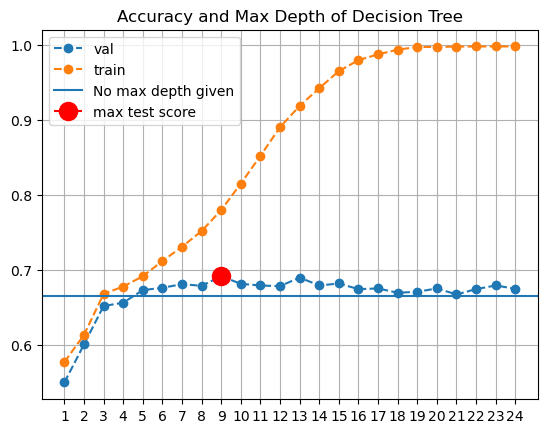

In [62]:
plt.plot(depths, tree_val_scores, '--o', label='val')
plt.plot(depths, tree_train_scores, '--o', label='train')
plt.axhline(y=comp.loc['accuracy', 'tree'], label='No max depth given') 
plt.plot(np.argmax(tree_val_scores)+1, max(tree_val_scores), 
         '--o', markersize = 13, color = 'red',
        label = 'max test score')
plt.grid()
plt.legend()
plt.xticks(depths)
plt.title('Accuracy and Max Depth of Decision Tree')


#### Tuning Random Forest

In [64]:
# depth

depths = list(range(1,25))

rf_train_scores = []
rf_val_scores = []
for d in depths:
    rf = RandomForestClassifier(max_depth=d, random_state=22)
#    pipe = Pipeline([('transform', transformer), ('rf', RandomForestClassifier(max_depth=d, random_state=22))])
    rf.fit(X_train_2, y_train_2)
    ts = rf.score(X_train_2, y_train_2)
    vs = rf.score(X_val, y_val)
    rf_train_scores.append(ts)
    rf_val_scores.append(vs)



Text(0.5, 1.0, 'Accuracy and Max Depth of Rf tree')

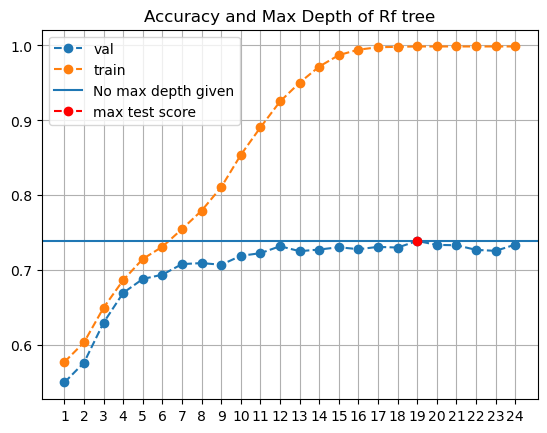

In [65]:
plt.plot(depths, rf_val_scores, '--o', label='val')
plt.plot(depths, rf_train_scores, '--o', label='train')
plt.axhline(y=comp.loc['accuracy', 'rf'], label='No max depth given') 
plt.plot((np.argmax(rf_val_scores)+1), max(rf_val_scores), 
         '--o', markersize = 6, color = 'red',
        label = 'max test score')
plt.grid()
plt.legend()
plt.xticks(depths)
plt.title('Accuracy and Max Depth of Rf tree')

Setting max depth at 16

In [67]:
# alpha 
alphas = [0, 0.00001, 0.0001, 0.0005, 0.001, 0.004, 0.008, 0.01, 0.015]
rf_train_a = []
rf_val_a = []

for a in alphas: 
    rf = RandomForestClassifier(ccp_alpha=a, random_state=22, max_depth=16)
    rf.fit(X_train_2, y_train_2)
    ts = rf.score(X_train_2, y_train_2)
    vs = rf.score(X_val, y_val)
    rf_train_a.append(ts)
    rf_val_a.append(vs)

Text(0.5, 1.0, 'Accuray of Random Forest Model with Values of ccp alpha')

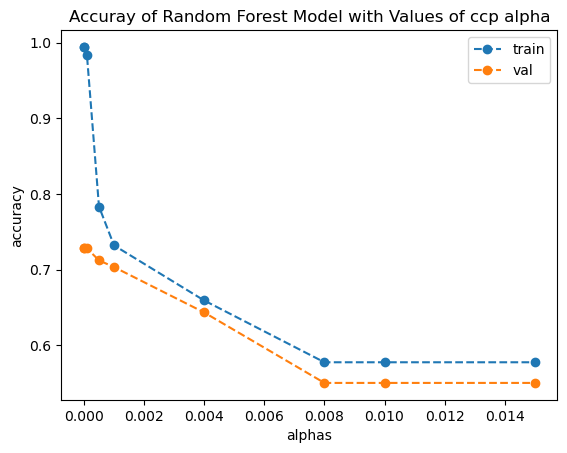

In [68]:
plt.plot( alphas, rf_train_a,'--o', label='train')
plt.plot( alphas, rf_val_a, '--o', label='val')
plt.xlabel('alphas')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuray of Random Forest Model with Values of ccp alpha')

will ignore alpha

In [70]:
# grid search cv random forest
params = {'n_estimators': [50, 100, 200, 300, 500], 'criterion': ['gini', 'entropy'], 'max_depth':[8, 12, 16]}
rf = RandomForestClassifier()
grid_rfa = GridSearchCV(rf, param_grid=params, cv=3)
grid_rfa.fit(X_train, y_train)



GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [8, 12, 16],
                         'n_estimators': [50, 100, 200, 300, 500]})

In [71]:
results_a = pd.DataFrame(grid_rfa.cv_results_)
print(f'rf Untuned: accuracy = {rf_acc.mean()}')
results_a.sort_values('rank_test_score')

rf Untuned: accuracy = 0.7394842408972394


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
27,1.095136,0.014687,0.068389,0.001263,entropy,16,200,"{'criterion': 'entropy', 'max_depth': 16, 'n_e...",0.750662,0.740066,0.734018,0.741582,0.006879,1
26,0.574445,0.026870,0.035620,0.000822,entropy,16,100,"{'criterion': 'entropy', 'max_depth': 16, 'n_e...",0.752318,0.742053,0.730374,0.741582,0.008965,2
14,2.705477,0.036789,0.205488,0.021168,gini,16,500,"{'criterion': 'gini', 'max_depth': 16, 'n_esti...",0.752318,0.739073,0.732362,0.741251,0.008291,3
13,1.682839,0.106822,0.104607,0.006172,gini,16,300,"{'criterion': 'gini', 'max_depth': 16, 'n_esti...",0.751325,0.742715,0.728718,0.740919,0.009316,4
29,2.836935,0.025591,0.177420,0.012383,entropy,16,500,"{'criterion': 'entropy', 'max_depth': 16, 'n_e...",0.747351,0.740728,0.733355,0.740478,0.005716,5
28,1.632851,0.021328,0.103823,0.002292,entropy,16,300,"{'criterion': 'entropy', 'max_depth': 16, 'n_e...",0.750662,0.737417,0.730374,0.739485,0.008411,6
11,0.553656,0.004763,0.038386,0.002926,gini,16,100,"{'criterion': 'gini', 'max_depth': 16, 'n_esti...",0.749338,0.737417,0.731368,0.739374,0.007466,7
10,0.317157,0.022371,0.022602,0.005476,gini,16,50,"{'criterion': 'gini', 'max_depth': 16, 'n_esti...",0.739735,0.746026,0.730043,0.738602,0.006574,8
12,1.268722,0.138089,0.073874,0.005962,gini,16,200,"{'criterion': 'gini', 'max_depth': 16, 'n_esti...",0.744702,0.736755,0.730374,0.737277,0.005861,9
9,2.372991,0.208710,0.155705,0.006680,gini,12,500,"{'criterion': 'gini', 'max_depth': 12, 'n_esti...",0.743046,0.738079,0.727393,0.736173,0.006531,10


In [ ]:
# grid search cv random forest: precision
params = {'n_estimators': [50, 100, 200, 300, 500], 'criterion': ['gini', 'entropy']}
rf = RandomForestClassifier(max_depth=16)
grid = GridSearchCV(rf, param_grid=params, cv=3, scoring='recall')
grid.fit(X_train, y_train)


In [ ]:
results = pd.DataFrame(grid.cv_results_)
print(f'rf Untuned: recall = {rf_rec}')
results.sort_values('rank_test_score')


In [ ]:
rf2_acc, rf2_pres, rf2_rec = CVS(RandomForestClassifier(n_estimators=300, criterion='entropy', max_depth=16), X_train, y_train)
print(rf2_acc.mean(), rf2_pres, rf2_rec)

#### Tuning XGBoost

In [ ]:
depths = list(range(1,16,2))

xg_train_scores = []
xg_val_scores = []
for d in depths:
    xg = GradientBoostingClassifier(max_depth=d, random_state=22)
#    pipe = Pipeline([('transform', transformer), ('rf', RandomForestClassifier(max_depth=d, random_state=22))])
    xg.fit(X_train_2, y_train_2)
    ts = xg.score(X_train_2, y_train_2)
    vs = xg.score(X_val, y_val)
    xg_train_scores.append(ts)
    xg_val_scores.append(vs)



In [ ]:
def plt_depth(depths, val_scores, train_scores):
    plt.plot(depths, val_scores, '--o', label='val')
    plt.plot(depths, train_scores, '--o', label='train')
    plt.grid()
    plt.legend()
    plt.xticks(depths)
    plt.title('XGBoost: Accuracy and max depth')
    

In [ ]:
plt_depth(depths, xg_train_scores, xg_val_scores)

In [ ]:
# xgboost
params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.2, 0.3, 0.4], 'max_depth': [5, 7]}
xg = GradientBoostingClassifier(max_depth=7)
xggrid = GridSearchCV(xg, param_grid=params, cv=3)
xggrid.fit(X_train, y_train)

In [ ]:
xgresults = pd.DataFrame(xggrid.cv_results_)
print(f'XGboost untuned: accuracy = {xgb_acc.mean()}')
xgresults.sort_values('rank_test_score')


In [ ]:
xg2_acc, xg2_pres, xg2_rec = CVS(GradientBoostingClassifier(learning_rate=0.2, n_estimators=100, max_depth=7), X_train, y_train)
print(xg2_acc, xg2_pres, xg2_rec)

## Comparing Models

### Parameters

rf_tuned: tuned max_depth (16), criterion (entropy), n_estimators (500). ccp_alpha made no significant difference.

xgboost_tuned: tuned max_depth (5), n_estimators (300), learning_rate (0.4)

xgboost_tuned: tuned max_depth (7), n_estimators (100), learning_rate (0.2)

### Comparison

In [ ]:
comp_tuned = comp
comp_tuned['rf_tuned'] = [rf2_acc.mean(), rf2_pres, rf2_rec]
comp_tuned['xgboost_tuned'] = [xg2_acc.mean(), xg2_pres, xg2_rec]
comp_tuned = comp_tuned.round(3)
comp_tuned

## Test Data

XGBoost is best for accuracy and precision, but Random Forest is best for recall

### XGBoost

In [ ]:
xg_final = GradientBoostingClassifier(max_depth=5, n_estimators=300, learning_rate=0.4)
xg_final.fit(X_train, y_train)


In [ ]:
xg_final_res = xg_final.predict(X_test)


In [ ]:
xgbf_acc = accuracy_score(y_test,xg_final_res)
xgbf_pres = precision_score(y_test, xg_final_res)
xgbf_rec = recall_score(y_test, xg_final_res)
print(xgbf_acc, xgbf_pres, xgbf_rec)
baseline_y = y_test.value_counts(normalize=True)[1]

print(baseline_y)

In [ ]:
df_test_xgb = pd.DataFrame({'baseline y': [baseline_y, None, None], 'XGBoost': [xgbf_acc, xgbf_pres, xgbf_rec]}, index=['accuracy', 'precision', 'recall'])
df_test_xgb = df_test_xgb.round(3)

df_test_xgb

In [ ]:
cm_xgb = confusion_matrix(y_test, xg_final_res)
cm_xgb_display = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
cm_xgb_display.plot()
plt.title('Confusion Matrix for XGBoost')

### Random Forest

In [ ]:
rf_final = RandomForestClassifier(max_depth=16, criterion='entropy', n_estimators=500)
rf_final.fit(X_train, y_train)


In [ ]:
rf_final_res = rf_final.predict(X_test)

In [ ]:
rff_acc = accuracy_score(y_test,rf_final_res)
rff_pres = precision_score(y_test, rf_final_res)
rff_rec = recall_score(y_test, rf_final_res)

In [ ]:
df_test_rf = pd.DataFrame({'baseline y': [baseline_y, None, None], 'RF': [rff_acc, rff_pres, rff_rec]}, index=['accuracy', 'precision', 'recall'])
df_test_rf = df_test_rf.round(3)

df_test_rf

In [ ]:
df_test_xgb

In [ ]:
cm_rff = confusion_matrix(y_test, rf_final_res)
cm_rff_display = ConfusionMatrixDisplay(confusion_matrix=cm_rff)
cm_rff_display.plot()
plt.title('Confusion Matrix for Random Forest')